# Context

This pair trading strategy is part of a school project initiated by the **Engineering School De Vinci (ESILV)** and **Systemathics** and led by **4** data scientist, analyst and fintech **students** with the task of carrying out quantitative research in order to implement a **pair trading strategy** using statistical data and artificial intelligence concepts. The goal is also to determine if one approach brings more added value to the results or not.

### Our contacts

* MUCHAN Deng : dengmuchan@gmail.com

* LORGNET Niels : niels.lorgnet@gmail.com

* LEGOFF Tristan : legoff.tristan.pro@gmail.com

* EL MERSHATI Laith : laith.elmershati@gmail.com


***Esilv website*** : https://www.esilv.fr/en/



# Introduction

*Pair trading* is a market-neutral strategy where a **long position in one stock and a short position in another stock are initiated simultaneously**. The profit principle of the trade is based on **mean reversion**, i.e., two stocks that normally trade in the same direction become temporarily uncorrelated and eventually will revert to the mean.

Therefore we can identify two major aspects regarding the implementation of this strategy. First, the **selection of the pairs** that needs to be correlated enough so that they revert to their mean and then the **execution of the strategy** based of some predefined trading rules.

## The selection of the pairs

As said before our pairs needs to be correlated enough so that when they become temporarly uncorrelated we can expect them to revert to their mean. An easy solution for that would be to calculate the correlation two by two for each existing stocks but that would be some extremely heavy and long computation to do therefore we would rather limit ourself to **equities that belongs to the same group/index** like the NASDAQ so that it will narrow our search zone. However we can still get a few steps ahead by gathering **stocks from the same sectors** since odds are that they will most likely move together within the same trend.

These steps constitute the preselection of the pairs. Now that equities are gathered by sectors within the same index we can carry out the correlation test and keep the satisfying pairs only. However the **correlation computation** is not be the best option that exists, indeed for this kind of strategy of pair trading we might prefer using the **stationarity** or the **cointegration**.

The reason behind looking for other options is that just looking at correlation might give us spurious results. For instance, if our pairs trading strategy is based on the spread between the prices of the two stocks, it is possible that the prices of the two stocks keep on increasing without ever mean-reverting, thus, one should be careful of using only correlation for pairs trading. This is why we would rather use the **cointegration** that is very similar to **stationarity**, indeed if A and B are cointegrated then it implies that the log of the ratio is stationary which suggests that the mean and variance remains constant over time.

## The strategy

As explained in details below in the "Stocks selection" and "Backtest Strategy" part, our model simply selects pairs of assets considered stationary over a period and trades on these pairs. Regularly the pairs to trade on are actualized. The spread formula, the position and sizing rules are given below, the goal of this model being to trade only on mean reversion opportunities.

___

# Pair selection

In [1]:
# ---------- INSTALLATION AND IMPORTATION ----------
from IPython.display import clear_output
!pip install googleapis-common-protos protobuf grpcio pandas systemathics.apis statsmodels matplotlib seaborn
clear_output(wait=True)
print("Install completed 100%")


Install completed 100%


In the *pair_selection* file is written the ```Selection``` class that contains lots of data about equities that belongs to a specific index and exchange as well as functions enabling us to do many computation on these data.

In [2]:
import pair_selection
from backtesting import Backtesting
from price_data import PriceData

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import grpc
import statistics
# from datetime import datetime
# import datetime
import google.type.date_pb2 as date
import google.type.dayofweek_pb2 as dayofweek
import google.type.timeofday_pb2 as timeofday
import google.protobuf.duration_pb2 as duration
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.services.daily.v1.daily_bars_pb2 as daily_bars
import systemathics.apis.services.daily.v1.daily_bars_pb2_grpc as daily_bars_service
from math import *

print("Import completed 100%")


/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Import completed 100%


## Stocks construction

We import our file and we create an object with the default variables except for the date which we define as from January 1st 2015. The construction of this object will take some time to make all the API calls to retrieve the information on the assets and then the prices of each.

In [3]:
s = pair_selection.Selection(start_date="2015-01-01")

Many variables can be adjusted or left as default, here is a full description :

* ***Param ```index``` :*** The index from which we want to get its equities.

***type :*** str | ***default :*** 'NASDAQ'

* ***Param ```exchange``` :*** The exchange from which we want to get its equities.
    
***type :*** str | ***default :*** 'XNGS'

* ***Param ```market_based_classification``` :*** The market based classification used to define sectors ('ICB', 'Nasdaq'...)
    
***type :*** str | ***default :*** 'Nasdaq'

* ***Param ```start_date``` :*** Collect the prices starting from that date (until now or today).
    
***type :*** str format YYYY-MM-DD | ***default :*** "2019-01-01"

* ***Param ```adjustment``` :*** Use the adjusted price or not.
    
***type :*** bool | ***default :*** False

* ***Param ```use_corr``` :*** Calculate the correlation between two equities or not.
    
***type :*** bool | ***default :*** False

* ***Param ```use_statio``` :*** Calculate the stationarity of a pair series or not.
    
***type :*** bool | ***default :*** True

* ***Param ```mincorr_level``` :*** Minimum level to consider two equities as correlated.
    
***type :*** float | ***default :*** 0.7

* ***Param ```statio_level``` :*** p-value used to invalidate the null hypothesis of a stationarity test.
    
***type :*** float | ***default :*** 0.05

* ***Param ```use_adfuller``` :*** Use Dickey Fuller stationarity test or not.
    
***type :*** bool | ***default :*** True

* ***Param ```use_kpss``` :*** Use kpss stationarity test or not.
    
***type :*** bool | ***default :*** False

* ***Param ```use_zivotandrews``` :*** Use zivot and andrews stationarity test or not.
    
***type :*** bool   | ***default :*** False

By default we have set the **stationarity** variable to *True* and the **correlation** one to *False* so we don't calculate it.

2 class variables are built during the initialization, they can be consulted by entering ```s.data``` and ```s.df_all_prices```.

* *data* is a dataframe gathering general information about the assets such as their name, ticker and sector among others. The sectors will be very useful to carry out a shortlisting of stocks between them before applying to them the stationary computation.

* *df_all_prices* is also a dataframe but it gathers the daily closing prices of all the assets between the starting date we've set in the constructor until the day the request was made.

## Stocks selection

In order to get the best pairs per period for our backtest we will call the function *get_alltime_best_pairs*. This function works like this :

From the starting date until last date and progressing in a **range of a specific interval** in months, it saves in a **json file** the pairs with a **satisfying correlation value and/or stationarity** following the instance variable criteria set and this **between two increasing months of a specific interval**. 

*We presume that start_date is 2015-03-01 and end_date is 2021-06-18, interval is 6 and repetition is 2. We will then start the computations on price data between 2015-03-01 and 2015-09-01 (+6 months), then do it again after 2 months: therefore between 2015-05-01 and 2015-11-01 etc until end_date is 2021-06-01.*

We keep the default repetition of the computation i.e. every month, but to have multiples files for backtesting purposes we need to vary the use of the correlation or not and the stationarity, but also the interval of months on which each computation is made. The goal is to have enough different outputs for the backtest and to only keep the best at the end, therefore we will also try with correlation only and both correlation and stationarity.

In [10]:
s.get_alltime_best_pairs(filename="json_best_pairs/semestrial_statio")

In [12]:
s.get_alltime_best_pairs(interval=12, filename="json_best_pairs/yearly_statio")

In [13]:
s.get_alltime_best_pairs(interval=4, filename="json_best_pairs/trimestrial_statio")

The three cells before only took into account the stationary result of a pair : if *p*value was under 5% then we could consider the pair as stationary and add it to the json file.

Now we try the mingling with the correlation, the pair will be considered as valid if stationary but also if correlated at at least 70% (values can be accessed and modified with ```self.mincorr_level=0.8``` for setting it at 80%).

In [14]:
s.use_statio = True # was already set to True by default
s.use_corr = True
s.get_alltime_best_pairs(filename="json_best_pairs/semestrial_statio_and_corr")

In [15]:
s.get_alltime_best_pairs(interval=12, filename="json_best_pairs/yearly_statio_and_corr")

In [16]:
s.get_alltime_best_pairs(interval=4, filename="json_best_pairs/trimestrial_statio_and_corr")

Same idea as before but this time only considering the correlation and not the stationarity anymore.

In [17]:
s.use_statio = False
s.use_corr = True
s.get_alltime_best_pairs(filename="json_best_pairs/semestrial_corr")

In [18]:
s.get_alltime_best_pairs(interval=12, filename="json_best_pairs/yearly_corr")

In [19]:
s.get_alltime_best_pairs(interval=4, filename="json_best_pairs/trimestrial_corr")

Here is an overview of what the first line ``s.get_alltime_best_pairs(filename="semestrial_statio")`` returns in the json file :

```json
{
    "2015-07-01": [
        [
            "SPLK",
            "INTU"
        ],
        [
            "MCHP",
            "NVDA"
        ],
        [
            "SPLK",
            "EA"
        ],
        [
            "ANSS",
            "CDNS"
        ],
        [
            "SPLK",
            "ATVI"
        ],
        [
            "CDNS",
            "ADBE"
        ],
        [
            "ADSK",
            "WDAY"
        ]
    ],
    "2015-08-01": [ " ... " ],
    "2015-09-01": [ " ... " ],
    " ... ": [ " ... " ],
}
```

<h1>Backtest Strategy</h1>

<h3>Strategy parameters</h3>
<p>  
    
**Pair Selection** : For the strategy we need a list of pairs. This is the work that has been done above. The different lists of pairs have been stored in json in the folder "./json_best_pair". So we need to specify to the backtest which file we want to access in order to load these pairs.

**Position entry**: We decide to short/long a pair when we find an opportunity among the stationary pairs defined during the selection (verification of the stationarity over the last 6 months). When the Spread is positive but falls below the defined upper threshold (0.017 here), we consider that there is a short opportunity: we short asset 1 and we long asset 2. We do exactly the opposite for long opportunities.

**Exiting the position**: There are three possibilities. If you exceed a defined stop loss, you exit the position the next day at the opening. If the position reaches a certain defined duration, you exit the position at the next market opening. Finally, if the spread returns to normal (0), we also exit the position since we consider that there is no more opportunity.

**Sizing of the position**: We define a maximum number n of possible trades at the same time (currently 2). On each position taken we invest 1/n of the portfolio. This approach could be largely improved since we do not take into account the volatility of the market or the 2 assets for example.

**Scalability**: The entry is simple: you enter in one time at the opening. If we had to manage large amounts, this could make the assets move. Instead, we could implement a progressive entry over the whole day.</p>

In [43]:
# Name of the json with the pair list
pair_file_name = 'semestrial_statio.json'

initial_wallet = 1000 #Starting wallet in $
max_positions = 2 #Maximum number of simultaneous positions

spread_window = 5 #Number of bars used to calculate spread
spread_limit = 0.017 #Threshold to consider arbitrage

z_score_window = 30
z_score_limit = 1.5

stop_loss_activation = True #If you want a stop loss
stop_loss_pct = 0.02 #Percentage of your stop loss

<h3>Download historical data of all pairs selected</h3>
<p>
    
For each selected pair we download the **adjusted OHLCV data** of the pair. This gives us for each pair a dataframe of 10 columns: 
'Open_1', 
High_1', 
Low_1', 
Close_1', 
'Volume_1', 
'Open_2', 
'High_2', 
'Low_2', 
'Close_2', 
'Volume_2'</p>

In [10]:
#Generate auth token
token = f"Bearer {os.environ['AUTH0_TOKEN']}"

#Initate price_data class
dataEngine = PriceData(token)

#Load pair selection data from json
f = open('./json_best_pairs/'+pair_file_name,)
bestPair = json.load(f)
f.close()

#Generate the list of dates we will work on later
dfDate = dataEngine.get_pair_df(ticker_1 = "AAPL", ticker_2 = "MSFT", limit = 1500)
dateList = dfDate.index.values

#Download historical data for each pair of pair selection
pairList = []
dfList = {}
for month in bestPair:
    for pair in bestPair[month]:
        clear_output(wait=True)
        try:
            dfList[pair[0]+'/'+pair[1]]
        except:
            print('download',pair[0]+'/'+pair[1])
            dfList[pair[0]+'/'+pair[1]] = dataEngine.get_daily_pair_candles(ticker_1 = pair[0], ticker_2 = pair[1], limit = 1500)
print(len(dfList),"historical pair data loaded")

162 historical pair data loaded


<h3>Load Spread in all pair dataframe</h3>

<p>
    
For our strategy we use a **spread** to determine our entry and exit position.  
The spread formula we use is as follows:  
$spread = log(\frac{c1}{r1}) - log(\frac{c2}{r2})$  
- c1 = close asset 1
- c2 = close asset 2
- r1 = close asset 1 $x$ days ago
- r2 = close asset 2 $x$ days ago
    
With $x =$ spread_window
</p>

Spread loaded 100%


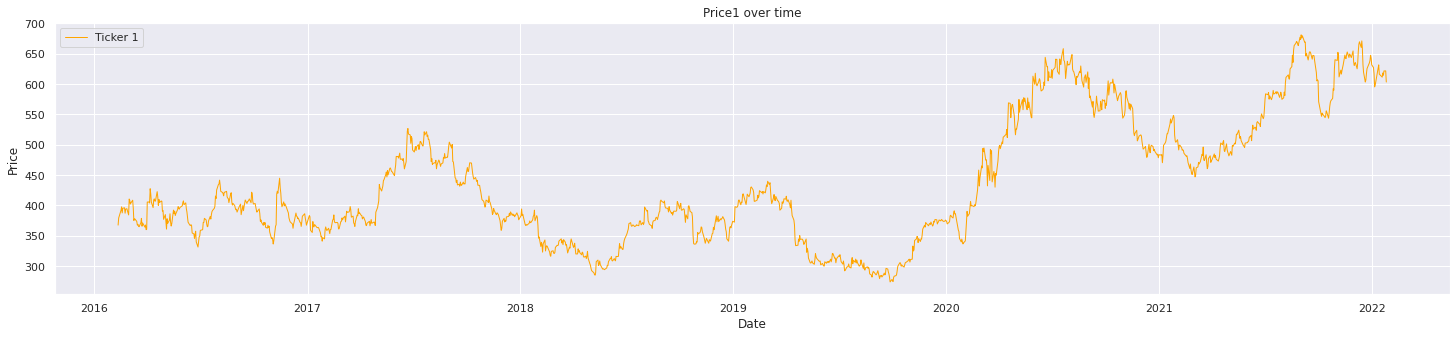

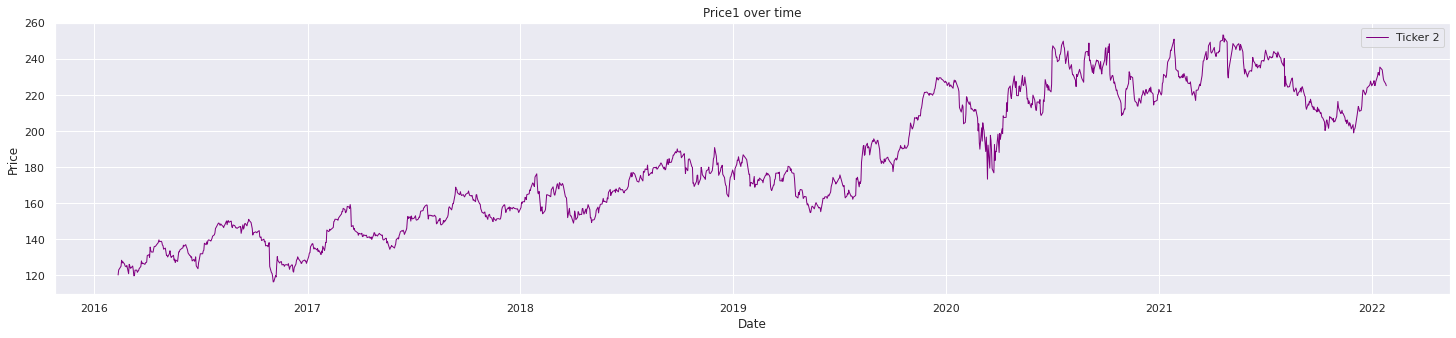

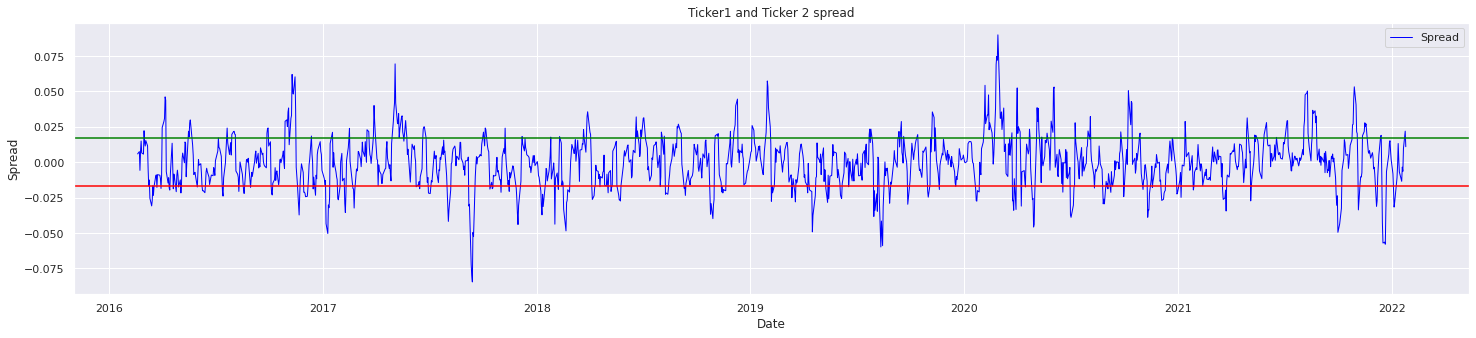

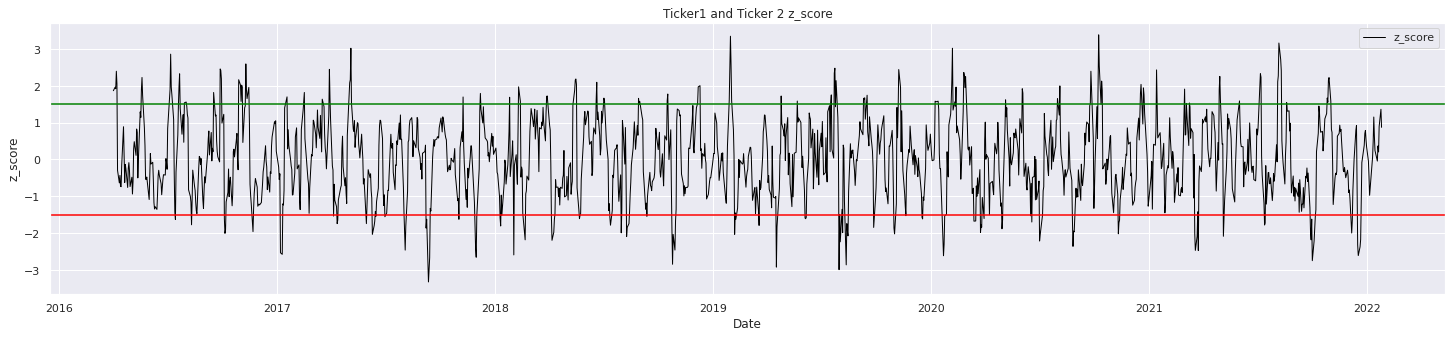

In [45]:
for df in dfList:
    dfList[df].drop(columns=dfList[df].columns.difference([
        'Open_1',
        'High_1',
        'Low_1',
        'Close_1',
        'Volume_1',
        'Open_2',
        'High_2',
        'Low_2',
        'Close_2',
        'Volume_2'
    ]), inplace=True)
    dfList[df]['Rol1'] = dfList[df]['Close_1'].shift(periods=spread_window)
    dfList[df]['Rol2'] = dfList[df]['Close_2'].shift(periods=spread_window)
    dfList[df]['Spread'] = np.log10(dfList[df]['Close_1'] / dfList[df]['Rol1']) - np.log10(dfList[df]['Close_2'] / dfList[df]['Rol2'])
    dfList[df]['z_score'] = (dfList[df]['Spread']-dfList[df]['Spread'].rolling(window=z_score_window).mean())/dfList[df]['Spread'].rolling(window=z_score_window).std()
    
print("Spread loaded 100%")
dfList[list(dfList.keys())[0]]

plt.figure(figsize=(25, 5))
plt.plot('Close_1', data=dfList[list(dfList.keys())[0]], marker='', color='orange', linewidth=1, label="Ticker 1")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price1 over time")
plt.legend()

plt.figure(figsize=(25, 5))
plt.plot('Close_2', data=dfList[list(dfList.keys())[0]], marker='', color='purple', linewidth=1, label="Ticker 2")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price1 over time")
plt.legend()

# display the ratio and its mean over the time
plt.figure(figsize=(25, 5))
plt.plot('Spread', data=dfList[list(dfList.keys())[0]], marker='', color='blue', linewidth=1, label="Spread")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price1 over time")
plt.legend()
plt.axhline(spread_limit, color='green')
plt.axhline(-spread_limit, color='red')
plt.xlabel("Date")
plt.ylabel("Spread")
plt.title("Ticker1 and Ticker 2 spread")

plt.figure(figsize=(25, 5))
plt.plot('z_score', data=dfList[list(dfList.keys())[0]], marker='', color='black', linewidth=1, label="z_score")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price1 over time")
plt.legend()
plt.axhline(z_score_limit, color='green')
plt.axhline(-z_score_limit, color='red')
plt.xlabel("Date")
plt.ylabel("z_score")
plt.title("Ticker1 and Ticker 2 z_score")



plt.legend()
plt.show()

<h3>Strategy funtions</h3>
<p>
    
This is where we define our functions that define our **position entry and exit**.

To open a **long** it is necessary that the previous spread value was above the predefined **threshold** and now it is below this threshold. This indicates a return to the mean. We close the long only when the spread has **returned to its average**.
    
It's the same for the **shorts** in the other direction

</p>

In [46]:
# def openLongCondition(row, previousRow):
#     if(row['Spread'] > -spread_limit and previousRow['Spread'] < -spread_limit):
#         return True
#     else:
#         return False
    
# def closeLongCondition(row, previousRow):
#     if(row['Spread'] > 0):
#         return True
#     else:
#         return False
    
# def openShortCondition(row, previousRow):
#     if(row['Spread'] < spread_limit and previousRow['Spread'] > spread_limit):
#         return True
#     else:
#         return False
    
# def closeShortCondition(row, previousRow):
#     if(row['Spread'] < 0):
#         return True
#     else:
#         return False

def openLongCondition(row, previousRow):
    if(row['z_score'] > -z_score_limit and previousRow['z_score'] < -z_score_limit):
        return True
    else:
        return False
    
def closeLongCondition(row, previousRow):
    if(row['z_score'] > 0):
        return True
    else:
        return False
    
def openShortCondition(row, previousRow):
    if(row['z_score'] < z_score_limit and previousRow['z_score'] > z_score_limit):
        return True
    else:
        return False
    
def closeShortCondition(row, previousRow):
    if(row['z_score'] < 0):
        return True
    else:
        return False

<h3>Backtest Cell</h3>

In [47]:
dfTestList = {}
for df in dfList:
    # dfTestList.append(df.loc['2021-11-01':'2021-11-10'])
    dfTestList[df] = dfList[df].loc[:]

#Value initialisation
trades = []
days = []
pairList = []
wallet = initial_wallet
temp_wallet = initial_wallet
n1index = dfTestList[list(dfTestList.keys())[0]].index.values[1]
n2index = dfTestList[list(dfTestList.keys())[0]].index.values[1]
lastMonth = str(dateList[0])[:7]
positionToRemove = []
activePositions = {}
usdRemaining = initial_wallet



# Get the result of one trade
def getTradeResult(position, price1, price2, lastPrice1, lastPrice2):
    evolPrice1 = (price1 - lastPrice1) / lastPrice1
    evolPrice2 = (price2 - lastPrice2) / lastPrice2
    if position == 'LONG':
        return evolPrice1-evolPrice2
    else:
        return evolPrice2-evolPrice1

for index in dateList:
    temp_wallet = wallet
    for pos in activePositions:
        n1Row = dfTestList[pos].loc[n1index]
        tempTradeResult = getTradeResult(
            activePositions[pos]["side"], 
            n1Row['Open_1'], 
            n1Row['Open_2'], 
            activePositions[pos]["initialPrice1"], 
            activePositions[pos]["initialPrice2"]
        )
        temp_wallet = wallet + tempTradeResult * activePositions[pos]["entrySize"]
    days.append({
        "day":index,
        "wallet":temp_wallet
    })
    
    # -- Update pair list --
    newMonth = str(index)[:7]+"-01"
    if newMonth != lastMonth:
        lastMonth = newMonth
        try:
            pairList = bestPair[lastMonth].copy()
        except:
            print('break here',lastMonth)
            break
                
    # -- Check if you have a position --
    if len(activePositions) > 0:
        for pos in activePositions:
            currentRow = dfTestList[pos].loc[index]
            n1Row = dfTestList[pos].loc[n1index]
            n2Row = dfTestList[pos].loc[n2index]
            if activePositions[pos]["side"] == "LONG":
                closeTradeResult = getTradeResult(
                    "LONG", 
                    n1Row['Close_1'], 
                    n1Row['Close_2'], 
                    activePositions[pos]["initialPrice1"], 
                    activePositions[pos]["initialPrice2"]
                )
                currentTradeResult = getTradeResult(
                    "LONG", 
                    currentRow['Open_1'], 
                    currentRow['Open_2'], 
                    activePositions[pos]["initialPrice1"], 
                    activePositions[pos]["initialPrice2"]
                )
                # -- Close LONG Stop Loss --
                if closeTradeResult < -stop_loss_pct and stop_loss_activation:
                    wallet = wallet + currentTradeResult * activePositions[pos]["entrySize"]
                    usdRemaining += activePositions[pos]["entrySize"] + currentTradeResult * activePositions[pos]["entrySize"]
                    try:
                        pairList.remove(pos.split('/'))
                    except:
                        pass
                    closeLongRow = {
                        'date': index,
                        'pair': pos,
                        'openOrClose':'Close', 
                        'position': "LONG", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'tradeResult': currentTradeResult,
                        'wallet': wallet,
                        'reason': 'Close Long Stop Loss'
                    }
                    positionToRemove.append(pos)
                    trades.append(closeLongRow)
                # Close LONG Market
                elif closeLongCondition(n1Row, n2Row) == True:
                    wallet = wallet + currentTradeResult * activePositions[pos]["entrySize"]
                    usdRemaining += activePositions[pos]["entrySize"] + currentTradeResult * activePositions[pos]["entrySize"]
                    closeLongRow = {
                        'date': index,
                        'pair': pos,
                        'openOrClose':'Close', 
                        'position': "LONG", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'tradeResult': currentTradeResult,
                        'wallet': wallet,
                        'reason': 'Close Long Market'
                    }
                    positionToRemove.append(pos)
                    trades.append(closeLongRow)

            elif activePositions[pos]["side"] == "SHORT":
                closeTradeResult = getTradeResult(
                    "SHORT", 
                    n1Row['Close_1'], 
                    n1Row['Close_2'], 
                    activePositions[pos]["initialPrice1"], 
                    activePositions[pos]["initialPrice2"]
                )
                currentTradeResult = getTradeResult(
                    "SHORT", 
                    currentRow['Open_1'], 
                    currentRow['Open_2'], 
                    activePositions[pos]["initialPrice1"], 
                    activePositions[pos]["initialPrice2"]
                )
                # -- Close SHORT Stop Loss --
                if closeTradeResult < -stop_loss_pct and stop_loss_activation:
                    wallet = wallet + currentTradeResult * activePositions[pos]["entrySize"]
                    usdRemaining += activePositions[pos]["entrySize"] + currentTradeResult * activePositions[pos]["entrySize"]
                    try:
                        pairList.remove(pos.split('/'))
                    except:
                        pass
                    closeShortRow = {
                        'date': index,
                        'pair': pos,
                        'openOrClose':'Close', 
                        'position': "SHORT", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'tradeResult': currentTradeResult,
                        'wallet': wallet,
                        'reason': 'Close Short Stop Loss'
                    }
                    positionToRemove.append(pos)
                    trades.append(closeShortRow)

                # Close SHORT Market
                elif closeShortCondition(n1Row, n2Row) == True:
                    wallet = wallet + currentTradeResult * activePositions[pos]["entrySize"]
                    usdRemaining += activePositions[pos]["entrySize"] + currentTradeResult * activePositions[pos]["entrySize"]
                    closeShortRow = {
                        'date': index,
                        'pair': pos,
                        'openOrClose':'Close', 
                        'position': "SHORT", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'tradeResult': currentTradeResult,
                        'wallet': wallet,
                        'reason': 'Close Short Market'
                    }
                    positionToRemove.append(pos)
                    trades.append(closeShortRow)
        # print(activePositions)
        # print(positionToRemove)
        for delPos in positionToRemove:
            del activePositions[delPos]
        positionToRemove = []
    # -- Check if you have no position --
    elif len(activePositions) < max_positions:
        for pair in pairList:
            # Break if you have opened a position
            if len(activePositions) >= max_positions:
                break
            try:
                currentRow = dfTestList[pair[0]+'/'+pair[1]].loc[index]
                n1Row = dfTestList[pair[0]+'/'+pair[1]].loc[n1index]
                n2Row = dfTestList[pair[0]+'/'+pair[1]].loc[n2index]
                if openLongCondition(n1Row, n2Row) == True:
                    usdMultiplier = 1/(max_positions-len(activePositions))
                    myEntry = usdMultiplier * usdRemaining
                    usdRemaining -= myEntry
                    activePositions[pair[0]+'/'+pair[1]] = {
                        "side":"LONG",
                        "entrySize":myEntry,
                        "initialPrice1":currentRow['Open_1'],
                        "initialPrice2":currentRow['Open_2'],
                    }
                    openLongRow = {
                        'date': index, 
                        'pair': pair[0]+'/'+pair[1],
                        'openOrClose':'Open', 
                        'position': "LONG", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'wallet': wallet,
                        'reason': 'Open Long Market',
                    }
                    trades.append(openLongRow)

                elif openShortCondition(n1Row, n2Row) == True:
                    usdMultiplier = 1/(max_positions-len(activePositions))
                    myEntry = usdMultiplier * usdRemaining
                    usdRemaining -= myEntry
                    activePositions[pair[0]+'/'+pair[1]] = {
                        "side":"SHORT",
                        "entrySize":myEntry,
                        "initialPrice1":currentRow['Open_1'],
                        "initialPrice2":currentRow['Open_2'],
                    }
                    openShortRow = {
                        'date': index, 
                        'pair': pair[0]+'/'+pair[1],
                        'openOrClose':'Open', 
                        'position': "SHORT", 
                        'price1': currentRow['Open_1'], 
                        'price2': currentRow['Open_2'],
                        'wallet': wallet,
                        'reason': 'Open Short Market',
                    }
                    trades.append(openShortRow)
            except e:
                print(e)
                pass
            
    n2index = n1index            
    n1index = index
    
dfTrades = pd.DataFrame(trades)
dfDays = pd.DataFrame(days)
print("Backtest finised 100%")
dfTrades

break here 2022-01-01
Backtest finised 100%


,date,pair,openOrClose,position,price1,price2,wallet,reason,tradeResult
0,2016-04-05,REGN/VRTX,Open,SHORT,401.850000,82.540000,1000.000000,Open Short Market,NaN
1,2016-04-11,REGN/VRTX,Close,SHORT,407.370000,85.960000,1013.848994,Close Short Market,0.027698
2,2016-04-12,REGN/VRTX,Open,LONG,396.330000,84.790000,1013.848994,Open Long Market,NaN
3,2016-04-13,REGN/VRTX,Close,LONG,411.240000,84.040000,1037.403518,Close Long Market,0.046466
4,2016-04-14,SWKS/INTC,Open,LONG,69.562972,27.320829,1037.403518,Open Long Market,NaN
...,...,...,...,...,...,...,...,...,...
797,2021-12-09,VRTX/GILD,Close,SHORT,207.960000,69.187240,1943.767171,Close Short Market,-0.011224
798,2021-12-10,ANSS/ADBE,Open,SHORT,399.180000,638.130000,1943.767171,Open Short Market,NaN
799,2021-12-13,ANSS/ADBE,Close,SHORT,398.500000,652.770000,1967.719753,Close Short Market,0.024646
800,2021-12-20,AVGO/MRVL,Open,SHORT,622.319053,82.668993,1967.719753,Open Short Market,NaN


In [48]:
backtest = Backtesting()
newDfTrades = backtest.complete_multi_backtest(dfTrades, dfDays, list(dfTestList.keys()))

Multi Pair Strategy
Period : [2016-04-05 00:00:00] -> [2021-12-28 00:00:00]

----- General Informations -----
Performance : 97.86 %
Sharpe ratio : 0.94
Best trade : +14.77 %, the 2017-11-30 00:00:00
Worst trade : -15.32 %, the 2018-07-13 00:00:00
Max DrawDown : -17.46 %, the 2018-10-01 00:00:00

----- Trades Informations -----
Total trades on period : 383
Number of positive trades : 213
Number of negative trades :  170
Trades win rate ratio : 55.61 %
Average trades performance : 0.37 %
Average positive trades : 2.45 %
Average negative trades : -2.22 %

----- LONG Trades Informations -----
Number of LONG trades : 194
Average LONG trades performance : 0.53 %
Best  LONG trade +14.49 %, the  2018-11-02 00:00:00
Worst LONG trade -15.32 %, the  2018-07-13 00:00:00
Number of positive LONG trades : 111
Number of negative LONG trades : 83
LONG trade win rate ratio : 57.22 %

----- SHORT Trades Informations -----
Number of SHORT trades : 207
Average SHORT trades performance : 0.21 %
Best  SHORT 

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -9.69
----- 2016 Performances: -3.31% -----


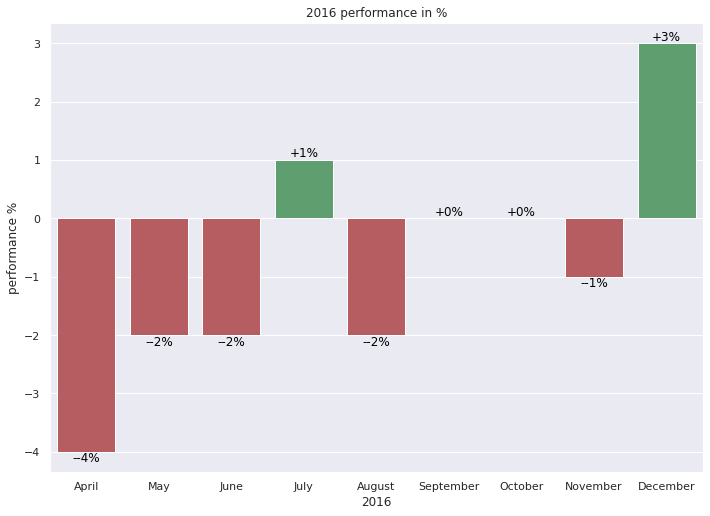

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -7.43
----- 2017 Performances: 17.46% -----


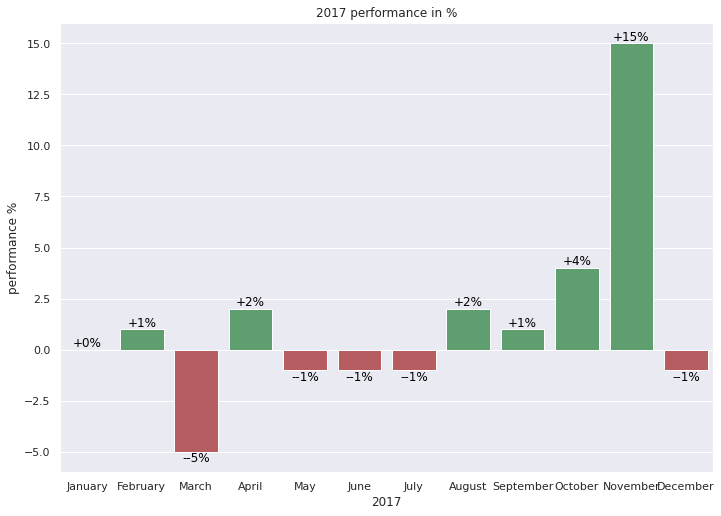

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -17.27
----- 2018 Performances: -7.69% -----


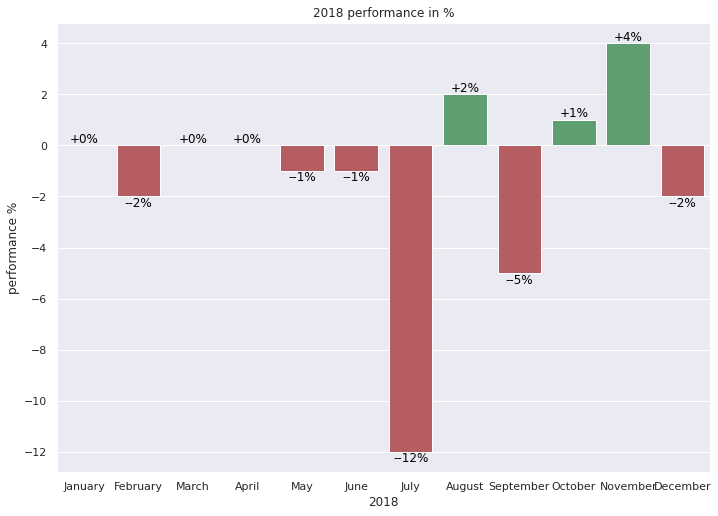

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -7.87
----- 2019 Performances: 18.67% -----


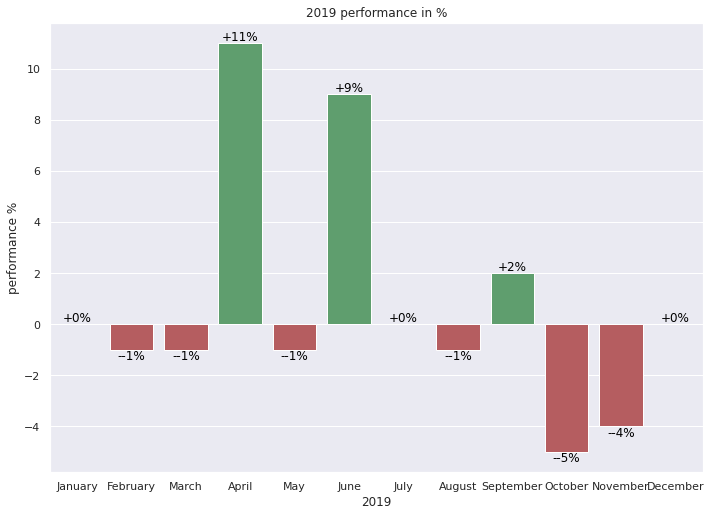

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -8.0
----- 2020 Performances: 21.8% -----


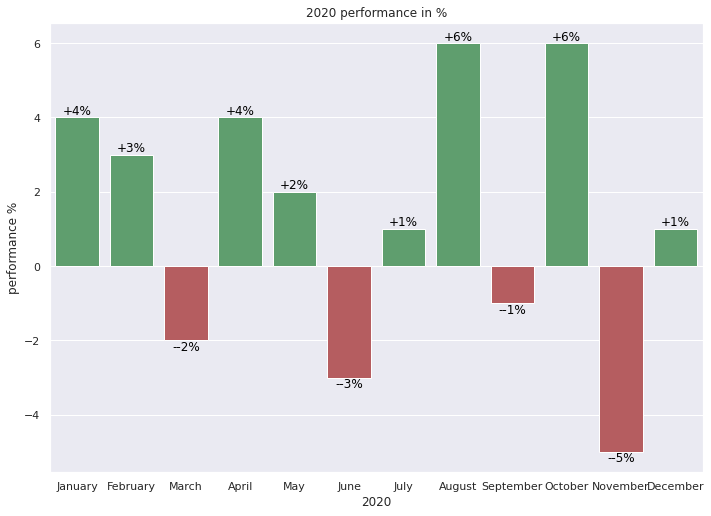

/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
/home/jovyan/Notebooks/Pair-Trading/10-Pair Trading/backtesting.py:257: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(my

Max DD -6.27 %
----- 2021 Performances: 31.67% -----
Annualized mean of 1.9513368577169634


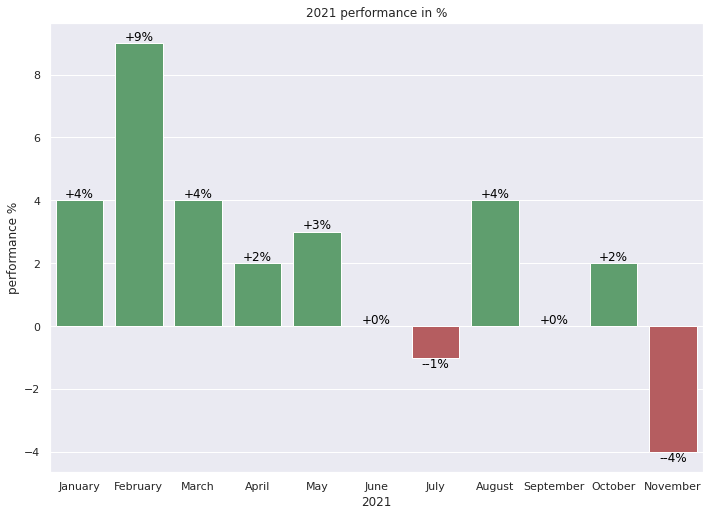

In [49]:
backtest.plot_bar_by_month(dfTrades)


----- Plot S&P500 vs Wallet evolution -----


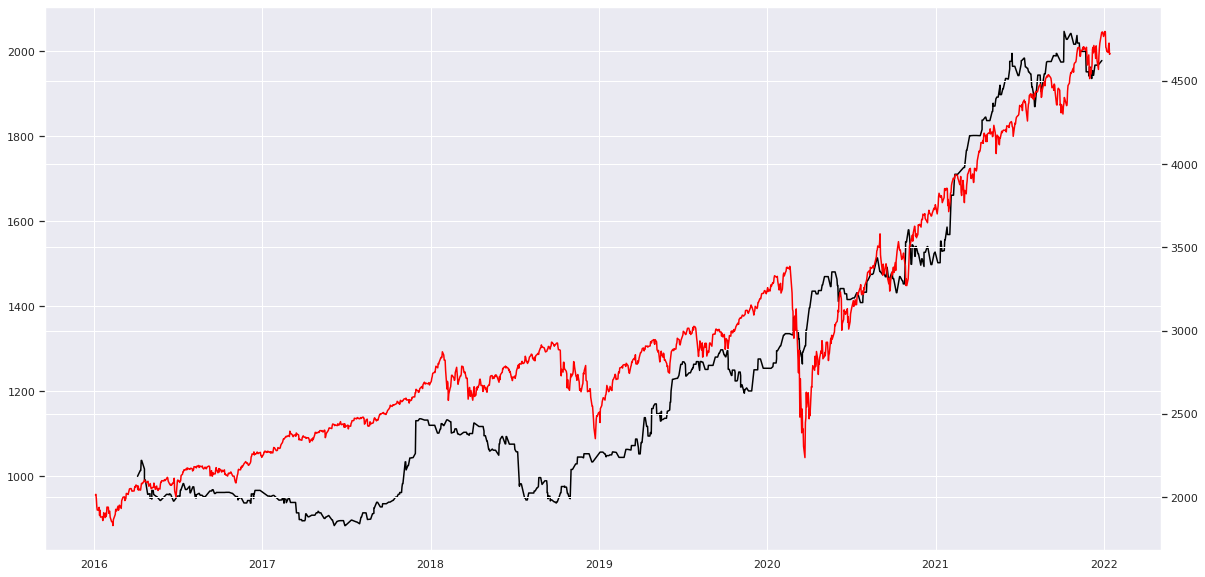

In [52]:
dfSP = pd.read_csv('SP_SPX, 1D.csv')

def plot_wallet_evolution(dfTrades, dfSP):
    fig, ax_left = plt.subplots(figsize=(20, 10))
    ax_right = ax_left.twinx()
    
    dfSPCopy = dfSP.copy()
    dfSPCopy = dfSPCopy.set_index(dfSPCopy['time'])
    dfSPCopy.index = pd.to_datetime(dfSPCopy.index, unit='s')
    dfSPCopy = dfSPCopy['2016':]
    
    dfTradesCopy = dfTrades.copy()
    dfTradesCopy = dfTradesCopy.set_index(dfTradesCopy['date'])
    dfTradesCopy.index = pd.to_datetime(dfTradesCopy.index)
    ax_left.plot(dfTradesCopy['wallet'], color='black')
    ax_right.plot(dfSPCopy['close'], color='red')
    print("\n----- Plot S&P500 vs Wallet evolution -----")
    
plot_wallet_evolution(dfTrades, dfSP)

<h1>Conclusion and critique of the project</h1>

<p>
The first question following the project is should you install this algorithm to manage part of your portfolio?    
In the current state of the strategy, I will have to answer you no.   
    
Indeed for us the results are not satisfactory, a sharpe ratio below 1, a drawdown around 20%. These are the 2 metrics that make us say that the strategy must be improved before entrusting it with funds.  
    
However, what are the positive points of the current strategy?  
The strategy still has a result of +85% over 5 years. While being market neutral. If we compare over the years tested, the performance is worse than the S&P500 or the Nasdaq but is it consistent to compare the performance to indexes knowing that the strategy is not affected by the general state of the market. Indeed, these performances could be reproduced even in a very bearish market, such as following the 2008 crisis.
    
This strategy can for example be used if you want to make your capital work and you do not want to be exposed to market variations. We also manage to more or less replicate the performance of the S&P500 while we are never in position on more than 2 pairs (4 assets) which can be a big advantage in terms of ease of execution and also less fees.
    
What are the points that could make this strategy better?
- Perhaps the first problem is the size of the positions, on each position here we take 50% of our portfolio. This creates too high risks. It would be good to be less selective in entering position but also in selecting pairs. This would allow us to increase the maximum number of positions that we could take without reducing the performance of the strategy.
- We also have a problem with very bad trades. We have a stop loss at 2% however our worst trade is at -16%. This is due to the fact that we are based on the closing and we take a position at the opening. For example if we have a signal at the close of Thursday. We will open a position at the opening on Friday. The position will remain open all weekend and can only be closed at the open on Tuesday. We have a lack of responsiveness which means that even with a 2% stop loss some positions lose much more. One solution would be, for example, to always close positions before the closing, especially before the weekend.
- The machine learning approach could also contribute to the strategy. For the moment the results are less good with a machine learning approach, whether at the level of pair selection or strategy. However, we ran out of time to deepen this point, in particular to do more tests with the selection of pairs with different parameters. For the strategy it is only a draft and it would be necessary to start again while seeing what is likely to work and what does not work.
- One point on which we are not at all focused is the sizing. It would be necessary to study the fact of entering and exiting positions in several times. It goes with risk management and portfolio management.
    
    
To conclude with strategy you will find a good outline of a pair trading strategy. You have a complete model to be able to test this type of strategy thanks to the backtest. However, it still needs to be improved if one day we want to be able to invest in this strategy.

</p>